<a href="https://colab.research.google.com/github/Robot-Wealth/rsims/blob/main/examples/rsims_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# rsims demo 

## Install and load

In R Studio, the simplest way to install `rsims` is:

`pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)`

In Colab, we can speed things up by installing dependencies separately:

In [1]:
# lists of libraries: rsims dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "dplyr", "tibble", "tidyr", "stringr", "magrittr", "ggplot2", 
"lubridate", "here", "Rcpp", "iterators", "R.methodsS3", "foreach", "R.oo", "R.utils"
)
libs_to_load <- c("tidyverse", "microbenchmark")

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", c(libs_to_load, dependencies), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rsims from GH (sans dependencies)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

* checking for file ‘/tmp/RtmpMrVmQs/remotes47621249b5/Robot-Wealth-rsims-e024593/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rsims_1.0.0.4.tar.gz’



## Workhorse Functions 

`rsims` has simulation functions for different scenarios:
- `fixed_commission_backtest`: uses a trade buffer approach to trading into target positions - crypto
- `min_commission_backtest`: uses a rebalance tolerance approach to trading into target positions - equities

Others will come as the need arises. 

They work in broadly the same way, but have slightly different inputs related to their cost models and trading approaches.

### Input prices and target positions

Both simulation functions require wide matrixes of prices and target positions. `rsims` is very opinionated about what these matrixes look like:
- identical dimensions (`rsims` will check this for you)
- identical date columns (`rsims` currently does a soft check on this - intending to develop further)
- first column needs to be a timestamp or date in Unix format
- one matrix contains prices, one column for each asset or product in the strategy’s universe
- the other matrix contains theoretical or ideal weights, again, one column for each asset in the strategy’s universe.
- Columns must map between the two matrixes: 
  - Column 1 is always the date or timestamp column 
  - Column 2 contains the prices and weights for the first asset 
  - Column 3 contains the prices and weights for the second asset 
  - etc

#### IMPORTANT

Timestamps must be aligned such that the price is the price at which you assume you can trade into the target position. 

This may require lagging of signals or target positions upstream of the simulation and is up to the user. 

Fortunately, the `tidyverse` tools provide a simple workflow for creating these matrixes and ensuring prices and target positions are aligned correctly. We'll run through an example. 

## Example 

Often, a natural product of the research process is a long dataframe consisting of tickers, dates, and target positions or theoretical weights. 

If this doesn't drop out of the research naturally, usually it's very easy to create. 

So this is our starting point for working with `rsims` - pretend that we've gone through our research process and arrived at such a dataframe, and also appended a prices column. 

Here's one I prepared earlier: `rsims` comes with such a data set for a crypto momentum strategy:

In [2]:
# load data that ships with rsims: a long dataframe
data(backtest_df_long)

head(backtest_df_long)

date,ticker,price,weight
<date>,<chr>,<dbl>,<dbl>
2015-04-22,BTC,2.338224e+02,0.10
2015-04-22,DASH,3.241223e+00,-0.10
2015-04-22,DGB,1.098965e-04,-0.06
2015-04-22,DOGE,1.091501e-04,-0.02
2015-04-22,LTC,1.441989e+00,0.02
2015-04-22,MAID,2.326495e-02,0.18


Warning message:
“Removed 266 row(s) containing missing values (geom_path).”


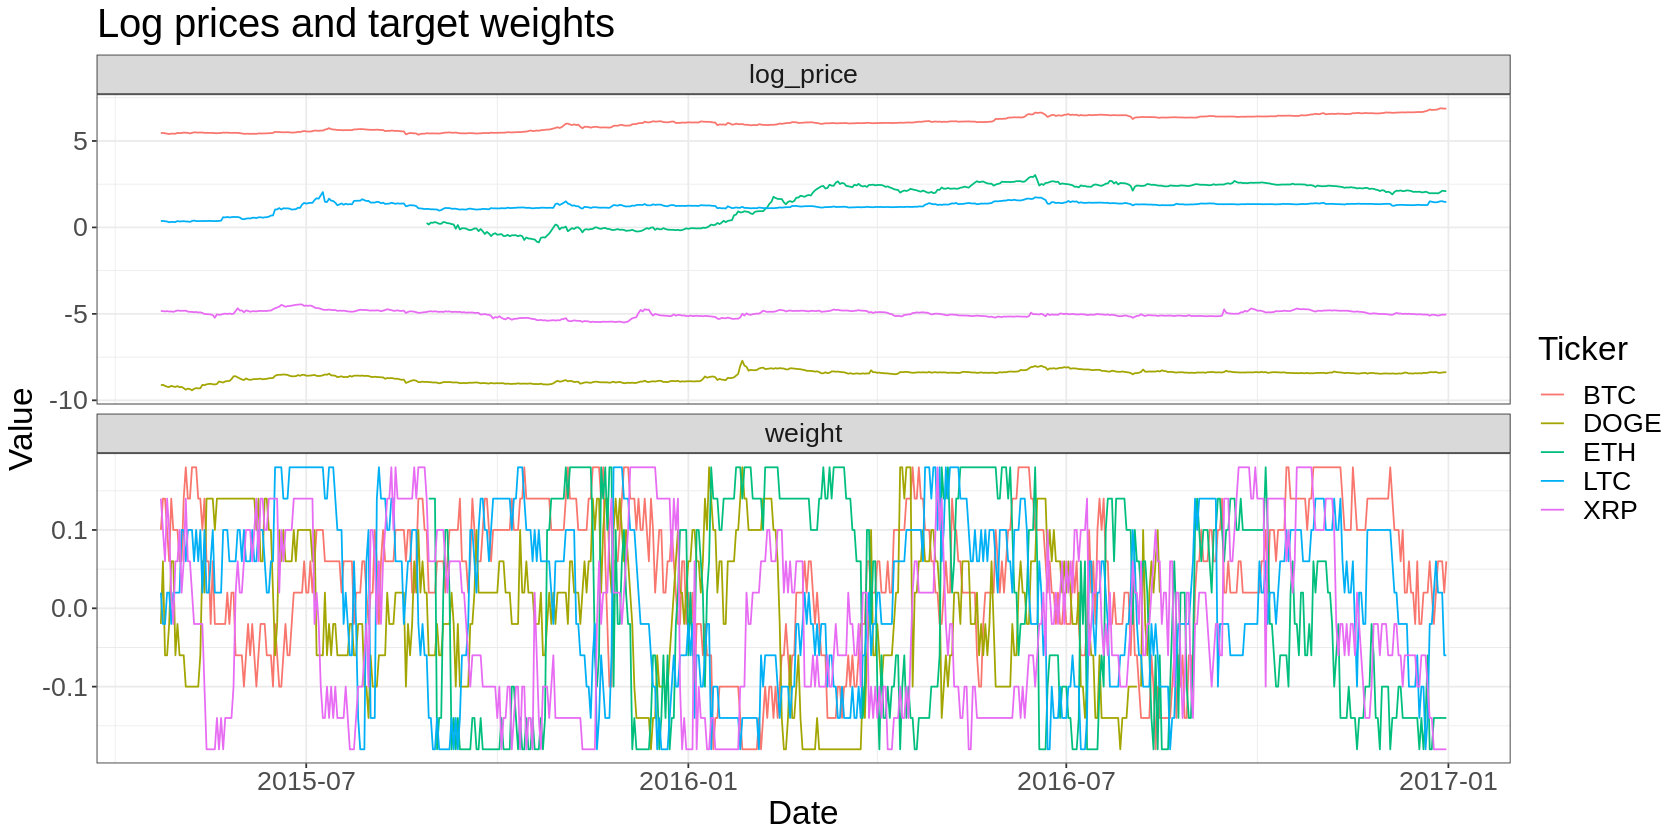

In [3]:
backtest_df_long %>%
  filter(ticker %in% c("BTC", "ETH", "DOGE", "XRP", "LTC")) %>%
  mutate(log_price = log(price)) %>%
  select(-price) %>%
  pivot_longer(c(-date, -ticker), names_to = "param", values_to = "value") %>%
  ggplot(aes(x = date, y = value, colour = ticker)) +
    geom_line() +
    facet_wrap(~param, scale = "free_y", ncol = 1) +
    labs(
      x = "Date",
      y = "Value",
      title = "Log prices and target weights",
      colour = "Ticker"
    )

#### Alignment of prices and weights 

The prices and weights are already correctly aligned in , but if you needed to lag your weights, `dplyr` makes this easy:

```R
backtest_df_long <- backtest_df_long %>%
  # double check that the df is arranged by date
  arrange(date) %>%
  # lag each ticker separately - otherwise we lag based on row order
  group_by(ticker) %>%
  # lag - specify dplyr::lag as there is also base::lag
  mutate(lagged_weight = dplyr::lag(weight, 1))
```

#### Create matrixes for prices and weights

The simplest way to create two matrixes that meet the requirements of rsims from our long dataframe is to use `tidyr::pivot_wider` to create a wide dataframe. 

Used as below, this function will guarantee that the prices and weights are aligned with their original date stamps from the long dataframe:

In [4]:
backtest_df_wide <- backtest_df_long %>% 
  tidyr::pivot_wider(id_cols = date, names_from = ticker, values_from = c(price, weight)) 

head(backtest_df_wide, 3)

tail(backtest_df_wide, 3)

date,price_BTC,price_DASH,price_DGB,price_DOGE,price_LTC,price_MAID,price_VTC,price_XEM,price_XMR,⋯,weight_CRV,weight_DOT,weight_NXM,weight_SUSHI,weight_UMA,weight_UNI,weight_SWRV,weight_AAVE,weight_ALPHA,weight_1INCH
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015-04-22,233.8224,3.241223,0.0001098965,0.0001091501,1.441989,0.02326495,0.008750427,0.0001381299,0.5797771,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2015-04-23,235.9333,3.667605,0.0001194309,0.0001113668,1.454306,0.02358372,0.008897387,0.0001368413,0.6059994,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2015-04-24,231.4586,3.203421,0.0001334753,0.0001046427,1.427716,0.02241484,0.008790541,0.0001468917,0.5715398,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


date,price_BTC,price_DASH,price_DGB,price_DOGE,price_LTC,price_MAID,price_VTC,price_XEM,price_XMR,⋯,weight_CRV,weight_DOT,weight_NXM,weight_SUSHI,weight_UMA,weight_UNI,weight_SWRV,weight_AAVE,weight_ALPHA,weight_1INCH
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-12-29,973.4626,10.83287,0.0002588563,0.0002273717,4.551954,0.10270309,0.03247505,0.003741609,13.08684,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2016-12-30,961.1827,11.20768,0.0002559600,0.0002298203,4.390304,0.10271433,0.03534768,0.003784324,12.87071,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2016-12-31,968.9706,11.41303,0.0002522993,0.0002302736,4.354112,0.09986612,0.03514540,0.003698567,13.88109,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Notice also that where a particular ticker didn't exist on a particular date, and therefore had no corresponding row in our long dataframe, that `pivot_wider` filled such entries with NA. We'll want to . 

The next step is to split our single wide dataframe into two matrixes. 

One difference between dataframes and matrixes is that matrixes must hold a common data type. Therefore, our date column (a `date` type) will need to be converted to a Unix-style (numeric) timestamp. R's `data.matrix` function will handle that automatically for us. 


First, the weights matrix:

In [13]:
# get weights as a wide matrix
# note that date column will get converted to unix timestamp
backtest_theo_weights <- backtest_df_wide %>% 
  # select only weight columns
  select(date, starts_with("weight_")) %>% 
  # remove the weight_ bit from the column names
  rename_with(.cols = -date, .fn = ~ str_remove(., "weight_")) %>%
  data.matrix()

head(backtest_theo_weights, c(5, 5))

date,BTC,DASH,DGB,DOGE
16547,0.10,-0.10,-0.06,-0.02
16548,0.14,-0.06,-0.10,0.06
16549,0.14,-0.10,0.10,-0.06
16550,0.10,-0.10,0.06,-0.06
16551,0.06,-0.06,0.14,-0.02


Now the prices matrix:

In [14]:
# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>% 
  # select only price columns
  select(date, starts_with("price_")) %>% 
  # remove the price_usd_ bit from the column names
  rename_with(.cols = -date, .fn = ~ str_remove(., "price_usd_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

date,BTC,DASH,DGB,DOGE
16547,233.8224,3.241223,0.0001098965,1.091501e-04
16548,235.9333,3.667605,0.0001194309,1.113668e-04
16549,231.4586,3.203421,0.0001334753,1.046427e-04
16550,226.4460,3.093542,0.0001222808,9.972296e-05
16551,220.5034,3.054431,0.0001227349,9.762035e-05


## Simulation 

And that's the hard work done! 

Now we can do interesting things like explore the trade-offs between costs and actively targeting our ideal positions. 

But first, let's look at a costless simulation that constantly trades back to the target weights:

In [17]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.

# simulation
results_df <- rsims::fixed_commission_backtest(
  backtest_prices, 
  backtest_theo_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
)

head(results_df, 10)

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2015-04-22,1.000000e+00,1.000000e+04,10000,NA,NA,0
BTC,2015-04-22,2.338224e+02,4.276750e+00,1000,4.276750e+00,1000,0
DASH,2015-04-22,3.241223e+00,-3.085255e+02,-1000,-3.085255e+02,-1000,0
DGB,2015-04-22,1.098965e-04,-5.459681e+06,-600,-5.459681e+06,-600,0
DOGE,2015-04-22,1.091501e-04,-1.832339e+06,-200,-1.832339e+06,-200,0
LTC,2015-04-22,1.441989e+00,1.386973e+02,200,1.386973e+02,200,0
MAID,2015-04-22,2.326495e-02,7.736962e+04,1800,7.736962e+04,1800,0
VTC,2015-04-22,8.750427e-03,6.856808e+04,600,6.856808e+04,600,0
XEM,2015-04-22,1.381299e-04,-1.303121e+07,-1800,-1.303121e+07,-1800,0


`rsims` returns simulation results as a long dataframe with a ticker-date combination on each row. The other columns are:
- Close: the closing price of the asset (or more precisely the price of the asset from the matrix of prices you used)
- Position: the number of units of the ticker you held on this day after any trading 
- Value: the dollar value of your position in this ticker on this day after any trading 
- Trades: the number of units bought or sold for this ticker on this day 
- TradeValue: the value of today's trades in this ticker 
- Commission: the dollar cost of the commission on today's trading in this ticker

## Post-Processing 

Since the simulation results come out in a nice long format dataframe, you can roll-your own post-processing functionality or use what's [built-in](https://github.com/Robot-Wealth/rsims/blob/main/R/post_processing.R) to `rsims`. 

(Currently some of the `rsims` post-processing tools are equities-specific, for instance caculating Sharpe by scaling by the square-root of 252 - if in doubt, roll your own. This is an [open issue](https://github.com/Robot-Wealth/rsims/issues/3) in `rsims` at the moment).

Here's how you might generate a pnl chart and some basic statistics:

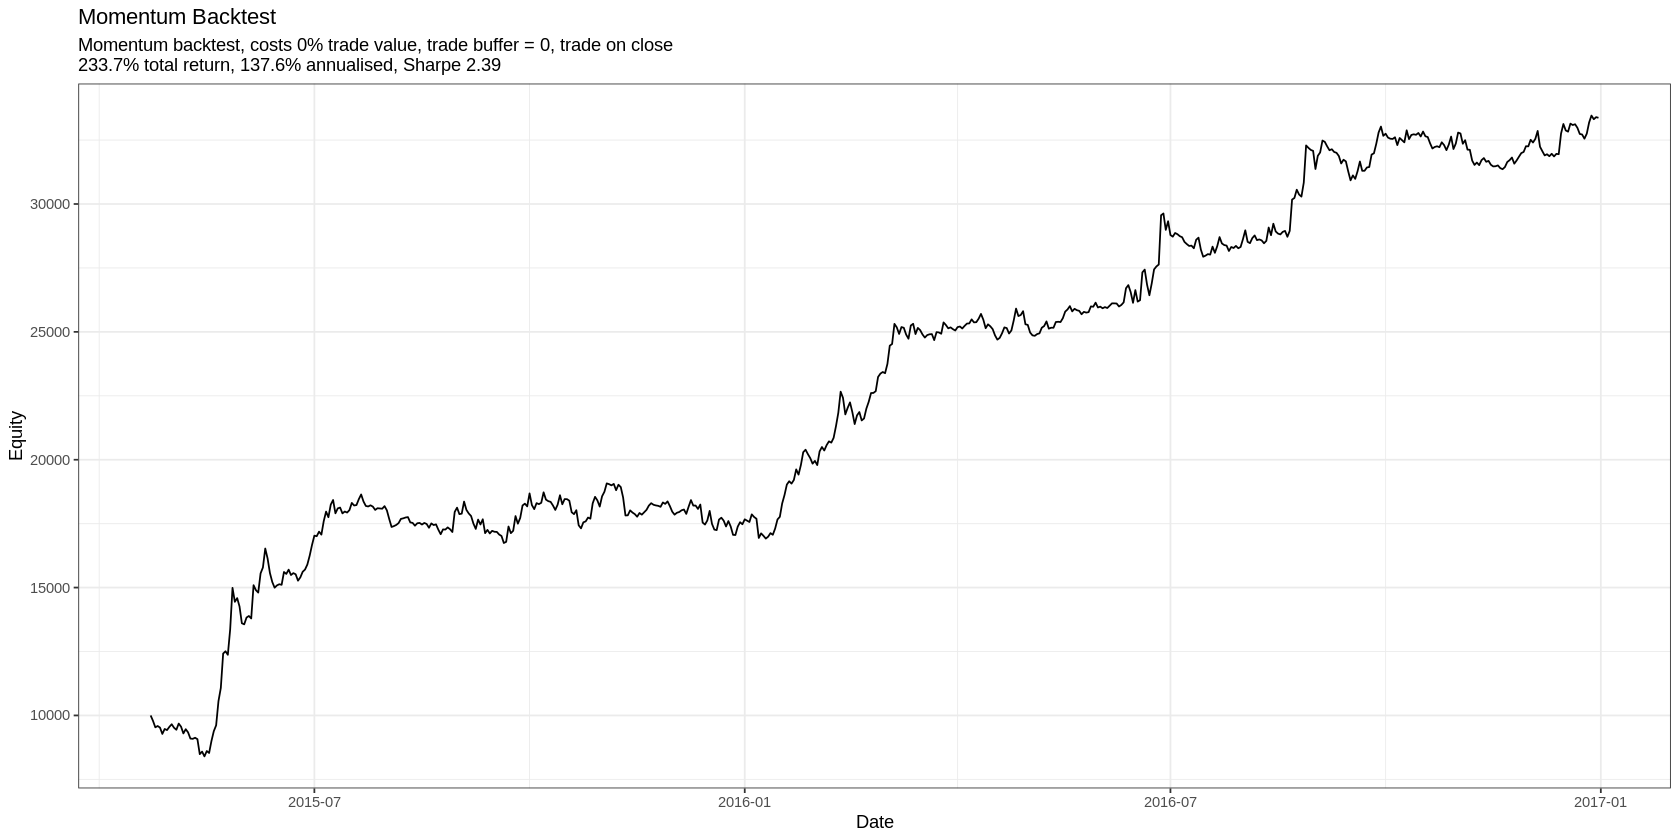

In [16]:
library(glue)

equity_curve <- results_df %>% 
  group_by(Date) %>% 
  summarise(Equity = sum(Value, na.rm = TRUE)) 

fin_eq <- equity_curve %>% 
  tail(1) %>% 
  pull(Equity)

init_eq <- equity_curve %>% 
  head(1) %>% 
  pull(Equity)

total_return <- (fin_eq/init_eq - 1) * 100
days <- nrow(equity_curve)
ann_return <- total_return * 365/days
sharpe <- equity_curve %>%
  mutate(returns = Equity/lag(Equity)- 1) %>%
  na.omit() %>%
  summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
  pull()

equity_curve %>% 
  ggplot(aes(x = Date, y = Equity)) +
    geom_line() +
    labs(
      title = "Momentum Backtest",
      subtitle = glue(
        "Momentum backtest, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close
        {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
      )
    ) +
  theme_bw()

## Exploring the trade offs between cost and active trading

One cool think about `rsims` is that its simulations are fast. That makes it efficient to run multiple simulations, for instance if you wanted to explore a specific trade off. 

Here's how you might explore how the simulated Sharpe ratio of the strategy changes as a function of the trade buffer parameter, assuming our costs are fixed at 0.1%:

In [21]:
# function for calculating Sharpe ratio given 365 day/year trading
calc_sharpe <- function(backtest_results) {
  backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
commission_pct <- 0.001

# run simulation for multiple trade buffer values 
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.005)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    rsims::fixed_commission_backtest(
      backtest_prices, 
      backtest_theo_weights, 
      trade_buffer, 
      initial_cash, 
      commission_pct, 
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes

[[1]]
[1] 2.213896

[[2]]
[1] 2.295467

[[3]]
[1] 2.361202

[[4]]
[1] 2.415359

[[5]]
[1] 2.449744

[[6]]
[1] 2.470761

[[7]]
[1] 2.499104

[[8]]
[1] 2.522444

[[9]]
[1] 2.531634

[[10]]
[1] 2.537357

[[11]]
[1] 2.544065

[[12]]
[1] 2.548108

[[13]]
[1] 2.553825

[[14]]
[1] 2.549921

[[15]]
[1] 2.551722

[[16]]
[1] 2.553033

[[17]]
[1] 2.546066

[[18]]
[1] 2.539433

[[19]]
[1] 2.513753

[[20]]
[1] 2.470432

[[21]]
[1] 2.41566

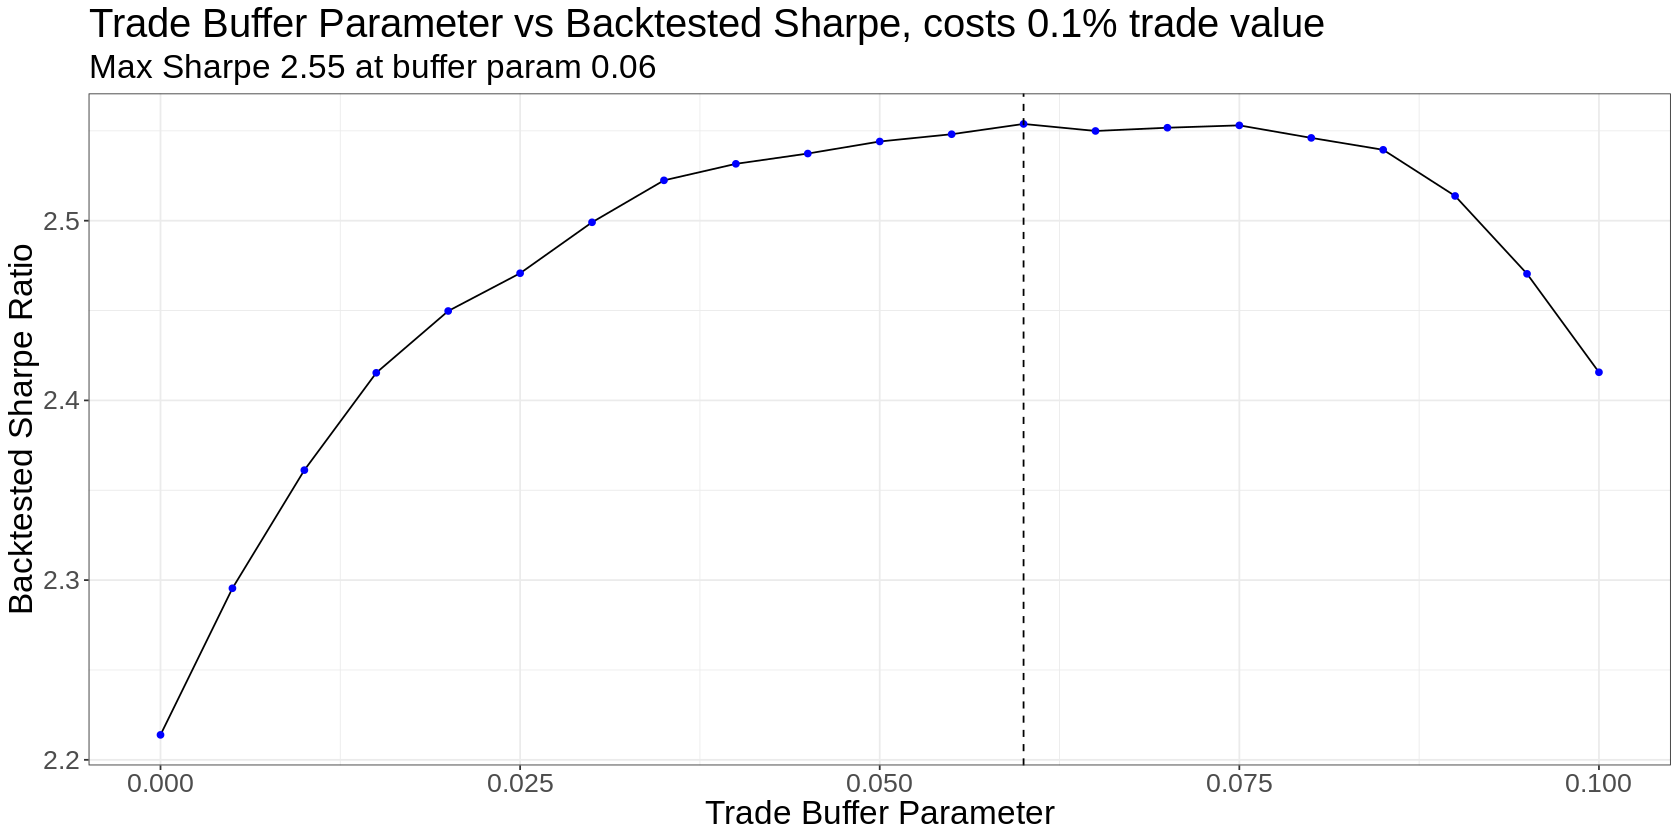

In [22]:
sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

## The need for speed

`rsims` is efficient for two reasons:
- it uses the natural outputs of the quant research process as the inputs for the simulation - no need to create complex signal-generation code in order to run a backtest
- it's fast

How fast?

We'll generate some prices and weights matrixes of various sizes and test.

First, a ten-year, 5-asset simulation:

In [41]:
# prices from gbm process
gbm_sim <- function(nsim = 100, t = 25, mu = 0, sigma = 0.1, S0 = 100, dt = 1./252) {

  # matrix of random draws - one for each day for each simulation
  epsilon <- matrix(rnorm(t*nsim), ncol = nsim, nrow = t)

  # get GBM paths
  gbm <- exp((mu - sigma * sigma / 2) * dt + sigma * epsilon * sqrt(dt)) - 1

  # convert to price paths
  gbm <- apply(rbind(rep(S0, nsim), gbm+1), 2, cumprod)

  return(gbm)
}

years <- 10
universe <- 5

# make ticker names
x <- 1
tickers <- vector()
repeat{
  tickers[[x]] <- paste0(sample(LETTERS, 5, replace = TRUE), collapse = "")
  x <- x + 1
  if(x == universe + 1)
    break
}

# make prices matrix
dates <- seq(as.numeric(as.Date("1980-01-01")), as.numeric(as.Date("1980-01-01"))+(years*365))
prices <- cbind(dates, gbm_sim(nsim = universe, t = years*365, mu = 0.01, sigma = 0.1))
colnames(prices) <- c("date", tickers)

# make weights matrix - weights are random normal
weights <- cbind(dates, rbind(rep(0, universe), matrix(rnorm(years*365*universe), nrow = years*365)))
colnames(weights) <- c("date", tickers)

prices_weights <- prices %>%
  as.data.frame() %>%
  mutate(date = as.Date(date, origin ="1970-01-01")) %>%
  pivot_longer(-date, names_to = "ticker", values_to = "price") %>%
  left_join(
    weights %>%
      as.data.frame() %>%
      mutate(date = as.Date(date, origin ="1970-01-01")) %>%
      pivot_longer(-date, names_to = "ticker", values_to = "theo_weight"),
    by = c("date", "ticker")
  )

  tail(prices_weights)

date,ticker,price,theo_weight
<date>,<chr>,<dbl>,<dbl>
1989-12-28,OXNMX,98.45130,0.4483246
1989-12-29,HWGJV,191.36901,-0.5425333
1989-12-29,HNYYF,107.49779,-0.4996177
1989-12-29,LTBBP,213.54784,0.1497501
1989-12-29,SZOXZ,96.36824,-1.0483867
1989-12-29,OXNMX,99.11756,-0.6955223


In [42]:
library(microbenchmark)

# simulation benchmarking
res <- microbenchmark(
  fixed_commission_backtest(
    prices,
    weights,
    trade_buffer = 0.,
    initial_cash = 1000,
    commission_pct = 0.001,
    capitalise_profits = FALSE
  ),
  times = 10
)

print(res)

Unit: milliseconds
                                                                                                                                       expr
 fixed_commission_backtest(prices, weights, trade_buffer = 0,      initial_cash = 1000, commission_pct = 0.001, capitalise_profits = FALSE)
      min       lq     mean   median       uq      max neval
 97.82043 99.15842 109.2447 112.3251 113.4276 121.4048    10


About 110 milliseconds for a ten-year, 5-asset simulation.

Next, a 10-year, 250-asset simulation:

In [43]:
years <- 10
universe <- 250

# make ticker names
x <- 1
tickers <- vector()
repeat{
  tickers[[x]] <- paste0(sample(LETTERS, 5, replace = TRUE), collapse = "")
  x <- x + 1
  if(x == universe + 1)
    break
}

# make prices matrix
dates <- seq(as.numeric(as.Date("1980-01-01")), as.numeric(as.Date("1980-01-01"))+(years*365))
prices <- cbind(dates, gbm_sim(nsim = universe, t = years*365, mu = 0.1, sigma = 0.1))
colnames(prices) <- c("date", tickers)

# make weights matrix - weights are random normal
weights <- cbind(dates, rbind(rep(0, universe), matrix(rnorm(years*365*universe), nrow = years*365)))
colnames(weights) <- c("date", tickers)

# simulation benchmarking
res <- microbenchmark(
  fixed_commission_backtest(
    prices,
    weights,
    trade_buffer = 0.,
    initial_cash = 1000,
    commission_pct = 0.001,
    capitalise_profits = FALSE
  ),
  times = 10
)

print(res)

Unit: milliseconds
                                                                                                                                       expr
 fixed_commission_backtest(prices, weights, trade_buffer = 0,      initial_cash = 1000, commission_pct = 0.001, capitalise_profits = FALSE)
      min       lq     mean  median       uq      max neval
 558.4001 562.7833 650.7688 645.042 741.8612 757.1339    10


About 650 milliseconds for a ten-year, 250-asset simulation.

Finally, a 20-year, 250-asset simulation:

In [44]:
years <- 20
universe <- 250

# make ticker names
x <- 1
tickers <- vector()
repeat{
  tickers[[x]] <- paste0(sample(LETTERS, 5, replace = TRUE), collapse = "")
  x <- x + 1
  if(x == universe + 1)
    break
}

# make prices matrix
dates <- seq(as.numeric(as.Date("1980-01-01")), as.numeric(as.Date("1980-01-01"))+(years*365))
prices <- cbind(dates, gbm_sim(nsim = universe, t = years*365, mu = 0.1, sigma = 0.1))
colnames(prices) <- c("date", tickers)

# make weights matrix - weights are random normal
weights <- cbind(dates, rbind(rep(0, universe), matrix(rnorm(years*365*universe), nrow = years*365)))
colnames(weights) <- c("date", tickers)

# simulation benchmarking
res <- microbenchmark(
  fixed_commission_backtest(
    prices,
    weights,
    trade_buffer = 0.,
    initial_cash = 1000,
    commission_pct = 0.001,
    capitalise_profits = FALSE
  ),
  times = 10
)

print(res)

Unit: seconds
                                                                                                                                       expr
 fixed_commission_backtest(prices, weights, trade_buffer = 0,      initial_cash = 1000, commission_pct = 0.001, capitalise_profits = FALSE)
      min       lq     mean   median       uq      max neval
 1.422541 1.436898 1.443653 1.445047 1.448984 1.471178    10


About 1.4 seconds for a 20-year, 250-asset simulation.

## Equities example

Equities are often traded under a minimum commission model. Unlike the fixed commission model, where you pay a commission based on the dollar value traded, beyond the minimum you pay a fixed amount per share traded. 

This means that the simulation needs to know how many shares were purchased to calculate commission accurately. Therefore, we need to provide both adjusted prices (for calculating total returns inclusive of dividends and corporate actions) and unadjusted prices (for calculating the number of shares traded at specific points in time). 

Here's how an equities simulation looks in `rsims`.

First, load the built-in equities data - a simple equal weight strategy, which we assume is the end point of our research into this strategy:

In [2]:
data(equal_weight_etfs)
head(equal_weight_etfs)

ticker,date,unadjusted_close,close,weight
<chr>,<date>,<dbl>,<dbl>,<dbl>
EMB,1995-01-04,40.22193,20.88572,0.1428571
GLD,1995-01-04,39.93568,39.80411,0.1428571
IEF,1995-01-04,43.80437,25.73871,0.1428571
TLT,1995-01-04,40.78683,21.15342,0.1428571
VEA,1995-01-04,22.07549,14.57201,0.1428571
VTI,1995-01-04,18.97111,13.25305,0.1428571


We prepare for simulation by again constructing wide matrixes, but this time we need three instead of two:
- adjusted prices
- unadjusted prices
- target weights

We create these matrixes in the same way we crated the crypto versions:

In [3]:
wide_prices <- equal_weight_etfs %>%
  select(ticker, date, close) %>%
  pivot_wider(date, names_from = ticker, values_from = close) %>%
  # dplyr::ungroup() %>%
  # fill(everything(), .direction = "down") %>%
  data.matrix()

# wide_prices[is.na(wide_prices)] <- 0

wide_unadjprices <- equal_weight_etfs %>%
  select(ticker, date, unadjusted_close) %>%
  pivot_wider(date, names_from = ticker, values_from = unadjusted_close) %>%
  # dplyr::ungroup() %>%
  # tidyr::fill(everything(), .direction = "down") %>%
  data.matrix()
# wide_unadjprices[is.na(wide_unadjprices)] <- 0

wide_weights <- equal_weight_etfs %>%
  select(ticker, date, weight) %>%
  pivot_wider(date, names_from = ticker, values_from = weight) %>%
  # dplyr::ungroup() %>%
  # tidyr::fill(everything(), .direction = "down") %>%
  data.matrix()

### TODO:

Explain additional parameters including elipsis, explain how different trade buffer trade module works in the presence of minimum commission costs.

In [4]:
results_df <- rsims::min_commission_backtest(
    wide_prices, 
    wide_unadjprices, 
    wide_weights, 
    trade_buffer = 0, 
    initial_cash = 10000, 
    capitalise_profits = TRUE, 
    leverage = 1, 
    us_tiered_commission, 
    max_pct_per_order = 0.01, 
    min_dollars_per_order = 0.35, 
    dollars_per_share = 0.0035
  )

tail(results_df)

ticker,date,close,shares,exposure,sharetrades,tradevalue,commission,margin_call
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
GLD,2021-09-30,164.22,11.571808,1900.322,-0.207060472,-34.0034707,0.35,FALSE
IEF,2021-09-30,115.22,16.918263,1949.322,0.004750523,0.5473552,0.35,FALSE
TLT,2021-09-30,144.32,13.305309,1920.222,0.023149183,3.3408902,0.35,FALSE
VEA,2021-09-30,50.49,39.890122,2014.052,0.181452710,9.1615473,0.35,FALSE
VTI,2021-09-30,222.06,8.297227,1842.482,0.114247890,25.3698865,0.35,FALSE
VWO,2021-09-30,50.01,40.282589,2014.532,-0.221075764,-11.0559989,0.35,FALSE


### TODO: output some other post-processing stuff,

Here's an example of using some of the built in tools to get trades for a subset of your universe. Explore the package for other post-processing tools. 

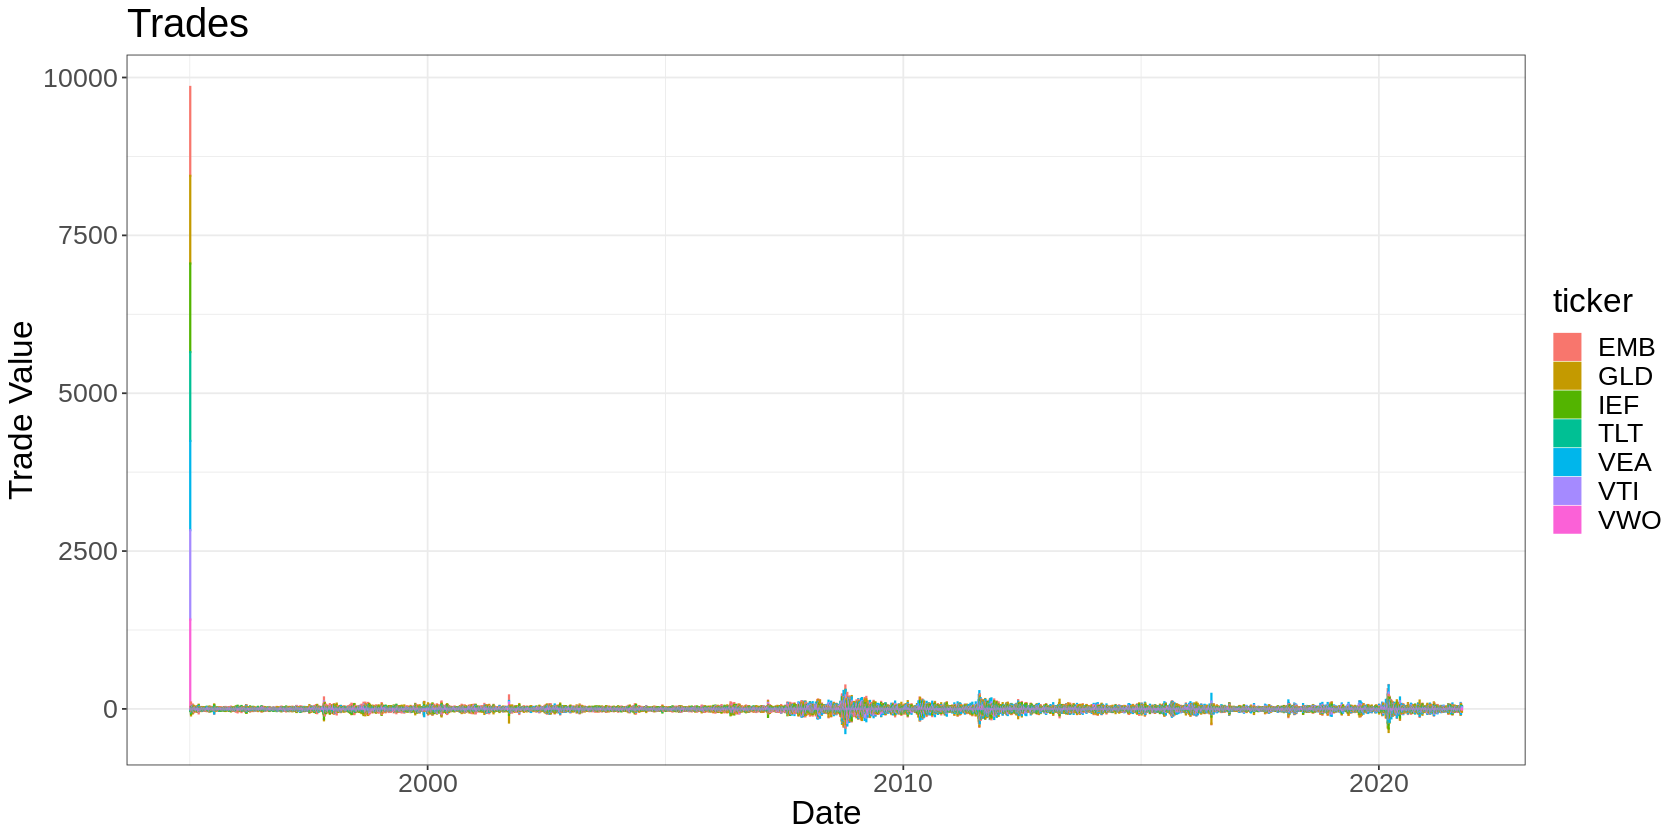

In [6]:
cols <- portfolio_colours(unique(equal_weight_etfs$ticker))
fill_scale <- make_fill_scale(cols)
colour_scale <- make_col_scale(cols)

results_df %>%
  trades_chart("Trades", fill_scale, colour_scale)